# Simple Detection Evaluation 

### Leval 1. Binary Evaluation - Species Present vs Not-Present in image
**Evaluating the performance of object detector on classifying task, i.e - performance on finding the species in images**

1. Overall Level
2. Species level

### Level 2. Species Count 
1. Overall level
2. Speceis level
3. Count level

### Level 3. Incorporate IoU
[Look at this when writing](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)

## Level 1: Overall Level
1. Filter out the images that were not user for model training
2. Make predictions on these images
    - wait, we can run the predictions on all the image and then do the step 1
3. Run the queries - predictorExtractor_main.py and prediction_groundtruth_consolidation_main.py
4. Evaluate predictions

In [5]:
# importing the necessary librabies
import csv, glob, sys
import pandas as pd
import numpy as np
import sklearn.metrics as metric
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

sys.path.append('/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/')
import data_prep.csv_shards_consolidation as csc
import data_prep.data_prep_utils as dataprep_utils

pd.options.display.max_columns=50

In [21]:
%%writefile /home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data_prep/csv_shards_consolidation.py

import pandas as pd

# Consolidate all the prediction_groundtruth shards
def combine_pred_groundtruth_consolidated_files(filepath_list):
    """This function combines all the small shards pred_groundtruth_consolidate_snapshot_serengeti_s01_s06
    into a big file.
    Parameter: filepath for the pred_groundtruth_consolidate_snapshot_serengeti_s01_s06*
    Return: consolidated datframe
    """
    df_pred_gt_consolidated = pd.DataFrame()
    list_temp = []
    for i, filepath in enumerate(filepath_list):
        df_pred_gt_temp = pd.read_csv(filepath)
#         df_pred_gt_temp = df_pred_gt_temp.fillna(0)
        list_temp.append(df_pred_gt_temp.shape[0]) # for use to check the correct append. len(list_temp)== 400
        df_pred_gt_consolidated = df_pred_gt_consolidated.append(df_pred_gt_temp)
    df_pred_gt_consolidated = df_pred_gt_consolidated.reset_index()
    df_pred_gt_consolidated = df_pred_gt_consolidated[['filename', 'species', 'labels', 'groundtruth_counts', 'prediction_counts']]
    return df_pred_gt_consolidated

# Consolidate all the TF Record decoded shards
def combine_tfr_decoded_predictions(filepath_list):
    """This function combines all the small shards pred_groundtruth_consolidate_snapshot_serengeti_s01_s06
    into a big file.
    Parameter: filepath for the pred_groundtruth_consolidate_snapshot_serengeti_s01_s06*
    Return: consolidated datframe
    """
    df_pred_gt_consolidated = pd.DataFrame()
    list_temp = []
    for i, filepath in enumerate(filepath_list):
        df_pred_gt_temp = pd.read_csv(filepath)
#         df_pred_gt_temp = df_pred_gt_temp.fillna(0)
        list_temp.append(df_pred_gt_temp.shape[0]) # for use to check the correct append. len(list_temp)== 400
        df_pred_gt_consolidated = df_pred_gt_consolidated.append(df_pred_gt_temp)
    df_pred_gt_consolidated = df_pred_gt_consolidated.reset_index()
    df_pred_gt_consolidated = df_pred_gt_consolidated[['filename', 'labels', 'score','xmax','xmin','ymax','ymin']]
    return df_pred_gt_consolidated

Writing /home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data_prep/csv_shards_consolidation.py


In [3]:
# Defining variabled
round_number = 'round1_ckpt69k'
round_number_base_files = 'round1'
filepath_list = glob.glob("/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/pred_snapshot_serengeti_s10_LB50p/{0}/Post_procession_of_infer_detection/pred_groundtruth_consolidate_msi_test_image_list_s10-*".format(round_number))

In [4]:
df_pred_gt_consolidated = csc.combine_pred_groundtruth_consolidated_files(filepath_list)
print(df_pred_gt_consolidated.shape)
print(df_pred_gt_consolidated[df_pred_gt_consolidated['groundtruth_counts'].notnull()].shape) # Ground Truth Counts
df_pred_gt_consolidated.tail()

(187686, 5)
(142745, 5)


,filename,species,labels,groundtruth_counts,prediction_counts
187681,S10/T11/T11_R2/S10_T11_R2_IMAG0335,zebra,5,NaN,1
187682,S10/T11/T11_R2/S10_T11_R2_IMAG1101,elephant,11,NaN,1
187683,S10/T11/T11_R2/S10_T11_R2_IMAG1113,elephant,11,NaN,1
187684,S10/T11/T11_R2/S10_T11_R2_IMAG1260,dikDik,4,NaN,1
187685,S10/T11/T11_R2/S10_T11_R2_IMAG1323,buffalo,14,NaN,1


### Level 1: Overall level

# Level 1. Species level

In [6]:
y_true = [not(pd.isnull(val)) for val in df_pred_gt_consolidated["groundtruth_counts"]]
y_pred = [not(pd.isnull(val)) for val in df_pred_gt_consolidated["prediction_counts"]]
print(sum(y_true), sum(y_pred))

tn, fp, fn, tp = metric.confusion_matrix(y_true, y_pred).ravel()
print(metric.confusion_matrix(y_true, y_pred))
print(tn, fp, fn, tp)

# For a classification task the recall is:
recall = round(tp/(tp + fn), 3) # Correct
precision = round(tp/(tp + fp), 3)
accuracy = round((tp)/(tp + fn), 3)
f1_score = round(2*recall*precision/(recall + precision), 3)

print("Recall: {0}".format(recall))
print("Precision: {0}".format(precision))
print("F1-Score: {0}".format(f1_score))
print("Accuracy: {0}".format(accuracy))
      

142745 174698
[[     0  44941]
 [ 12988 129757]]
0 44941 12988 129757
Recall: 0.909
Precision: 0.743
F1-Score: 0.818
Accuracy: 0.909


Confusion matrix, without normalization
[[     0  44941]
 [ 12988 129757]]


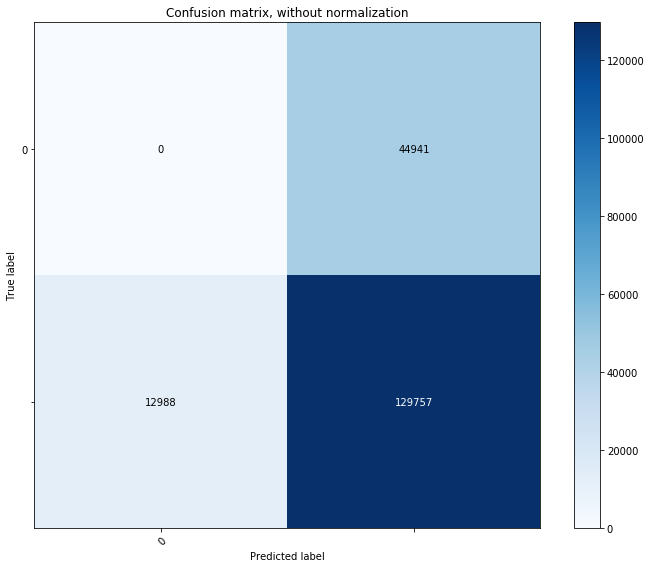

In [7]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          round_number,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metric.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig('./Dashboard/Species_level_overall_confusion_matrix_{0}.jpg'.format(round_number))
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, round_number = round_number, classes=np.array(['1', '0']),
                      title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plot_confusion_matrix(y_true, y_pred, classes=np.array(['false', 'true']), normalize=True,
#                       title='Normalized confusion matrix')

plt.show()


# Writing the callable function

In [11]:
%%writefile model_evaluation_metrics.py
# importing the necessary librabies
import csv, glob
import pandas as pd
import numpy as np
import sklearn.metrics as metric
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels


"""Evaluation at 3 levels:
1. Binary Classification
    a. Overall level - correctly find all the animals in the image
    b. Species level - Correctly find animal in the image
2. Count Level (wip)

3. With IoU (wip)
"""

def get_binary_classifcation_overall_perfomance(pred_groundtruth_consolidate_df):
    """1. a:
    Calculates the overall accuracy of the model. 
    input: DataFrame(output of this code - prediction_groundtruth_consolidation_main) 
            with predictions and groundtruth consolidated.
    output: Accuracy on classification for images. 
            Ex - if the GroundTruth has ['lion', 'cats'] and predictions has ['lion', 'cats'] - Correct,
            else Incorrect
            Precision
    """
    df_pred_gt_consolidated_inter = pred_groundtruth_consolidate_df.to_dict(orient='index')
    df_pred_gt_consolidated_dict = {}
    for k, v in df_pred_gt_consolidated_inter.items():
        if v['filename'] not in df_pred_gt_consolidated_dict.keys():
            df_pred_gt_consolidated_dict[v['filename']] = {}
            if pd.isnull(v['prediction_counts']) or pd.isnull(v['groundtruth_counts']):
                df_pred_gt_consolidated_dict[v['filename']]['correct_class'] = 0
                df_pred_gt_consolidated_dict[v['filename']]['incorrect_class'] = 1
            else:
                df_pred_gt_consolidated_dict[v['filename']]['correct_class'] = 1
                df_pred_gt_consolidated_dict[v['filename']]['incorrect_class'] = 0

        else:
            if pd.isnull(v['prediction_counts']) or pd.isnull(v['groundtruth_counts']):
                df_pred_gt_consolidated_dict[v['filename']]['correct_class'] += 0
                df_pred_gt_consolidated_dict[v['filename']]['incorrect_class'] += 1
            else:
                df_pred_gt_consolidated_dict[v['filename']]['correct_class'] += 1
                df_pred_gt_consolidated_dict[v['filename']]['incorrect_class'] += 0
    
    df_pred_gt_consolidated_leve1_class = pd.DataFrame(df_pred_gt_consolidated_dict).transpose().reset_index()
    # The overall classification accuracy
    correct_df = df_pred_gt_consolidated_leve1_class[(df_pred_gt_consolidated_leve1_class.correct_class>=1) \
                                        & (df_pred_gt_consolidated_leve1_class.incorrect_class==0)]
    accuracy = sum(correct_df.correct_class)/len(set(df_pred_gt_consolidated_leve1_class.index))
    precision = sum(df_pred_gt_consolidated_leve1_class.correct_class)/ \
                            (sum(df_pred_gt_consolidated_leve1_class.correct_class) + \
                             sum(df_pred_gt_consolidated_leve1_class.incorrect_class))
    print("The overall accuracy in classification: {0}".format(round(accuracy, 3)))
    print("The overall precision in classification: {0}".format(round(precision, 3)))
    return accuracy, precision

def get_binary_classifcation_species_level_perfomance(pred_groundtruth_consolidate_df):
    """
    1. b - Species level classification metric. 
    """
    # Overall Species Level
    y_true = [not(pd.isnull(val)) for val in pred_groundtruth_consolidate_df["groundtruth_counts"]]
    y_pred = [not(pd.isnull(val)) for val in pred_groundtruth_consolidate_df["prediction_counts"]]
    tn, fp, fn, tp = metric.confusion_matrix(y_true, y_pred).ravel()
    # For a classification task the recall is:
    recall = round(tp/(tp + fn), 3) # Correct
    precision = round(tp/(tp + fp), 3)
    accuracy = round((tp)/(tp + fn), 3)
    f1_score = round(2*recall*precision/(recall + precision), 3)
    
    print("Level 1: Species Level Overall")
    print("Recall: {0}".format(recall))
    print("Precision: {0}".format(precision))
    print("F1-Score: {0}".format(f1_score))
    print("Accuracy: {0}".format(accuracy))
    
    # Per Species Level
    species_level_performance_binary = {}
    for species in set(pred_groundtruth_consolidate_df['species']):
        species_level_performance_binary[species] = {}
        error = False
        df_temp = pred_groundtruth_consolidate_df[pred_groundtruth_consolidate_df['species']==species]
        y_true = [not(pd.isnull(val)) for val in df_temp["groundtruth_counts"]]
        y_pred = [not(pd.isnull(val)) for val in df_temp["prediction_counts"]]
        try:
            tn, fp, fn, tp = metric.confusion_matrix(y_true, y_pred).ravel()
        except Exception:
    #         y_true = [2] # to know why this exception run this code
    #         y_pred = [2]
    #         int(confusion_matrix(y_true, y_pred))
            tn, fp, fn, tp = 0, 0, 0, int(metric.confusion_matrix(y_true, y_pred))
            pass

        species_level_performance_binary[species]['TP'] = tp
        species_level_performance_binary[species]['FP'] = fp
        species_level_performance_binary[species]['TN'] = tn
        species_level_performance_binary[species]['FN'] = fn
        
    return species_level_performance_binary

Overwriting model_evaluation_metrics.py


**Evaluating the level performance for (Recall vs Precision) vs Size**

In [4]:
# Gather all the dataset on which to perform the evaluation
import sys, glob
import pandas as pd
# import sklearn.metrics as metric

sys.path.append('./')
import model_evaluation_metrics as mem

filepath_list = glob.glob("/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/pred_snapshot_serengeti_s10_LB50p/{0}/Post_procession_of_infer_detection/pred_groundtruth_consolidate_msi_test_image_list_s10-*".format(round_number))

df_pred_gt_consolidated = csc.combine_pred_groundtruth_consolidated_files(filepath_list)
## ------------------------------ ##
# 1.a - overall performance
## ------------------------------ ##
accuracy = mem.get_binary_classifcation_overall_perfomance(df_pred_gt_consolidated)

## ------------------------------ ##
# 1.b - Species Level
## ------------------------------ ##
multi_class_confusion_matrix = mem.get_binary_classifcation_species_level_perfomance(df_pred_gt_consolidated)
species_level_performance_binary_df = pd.DataFrame(multi_class_confusion_matrix).transpose().reset_index()
# species_level_performance_binary_df.to_csv('species_level_performance_binary_df.csv', index=False)
species_level_performance_binary_df['Precision'] = \
    species_level_performance_binary_df['TP']/(species_level_performance_binary_df['TP']+species_level_performance_binary_df['FP'])
species_level_performance_binary_df['Recall'] = \
    species_level_performance_binary_df['TP']/(species_level_performance_binary_df['TP']+species_level_performance_binary_df['FN'])
species_level_performance_binary_df['Accuracy'] = \
     species_level_performance_binary_df['TP']/(species_level_performance_binary_df['TP']+species_level_performance_binary_df['FN'])

#### Create a Dataframe with Species to Training Data distribution for the model being evaluated
metric_temp = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/EDA_and_ModelEvaluation/bootstrap_LowerBound50p/Training_data_{0}.csv'.format(round_number_base_files)

df_temp_gt = pd.read_csv(metric_temp)
df_temp_gt = df_temp_gt[['Species', 'Training_Data_Size', 'Training_Data_freq_normalized']]
# df_temp_gt.head()
#### Creating a DataFrame with Species distribution in the Test Dataset
df_temp_pred = df_pred_gt_consolidated[df_pred_gt_consolidated['groundtruth_counts'].notnull()].groupby(by=['species'], as_index=False)['filename'].count()
df_temp_pred.columns = ['species', 'Test_Data_Size']
df_temp_pred['Test_Data_freq_normalized'] = df_temp_pred['Test_Data_Size']/sum(df_temp_pred['Test_Data_Size'])

#### Merging the frequency for distributions for trainig and ground truth!
df_distribution_gt_pred = pd.merge(left=df_temp_gt,
                                   right=df_temp_pred,
                                   left_on=df_temp_gt['Species'],
                                   right_on=df_temp_pred['species'],
                                   how='left'
                                  )
df_distribution_gt_pred = df_distribution_gt_pred.drop(columns=['key_0', 'species'])
df_distribution_gt_pred['GT_TD_diff'] = \
                    df_distribution_gt_pred.Training_Data_freq_normalized/df_distribution_gt_pred.Test_Data_freq_normalized
df_distribution_gt_pred.head()

#### Merging the Distribution data for Groundtruth and Predictions into the species level performance metric
species_level_performance_binary_df = pd.merge(left=species_level_performance_binary_df,
                                               right=df_distribution_gt_pred,
                                               left_on=species_level_performance_binary_df['index'],
                                               right_on=df_distribution_gt_pred['Species'],
                                               how='left'
                                              )
species_level_performance_binary_df = species_level_performance_binary_df.drop(columns=['key_0', 'index'])

The overall accuracy in classification: 0.734
The overall precision in classification: 0.691
Level 1: Species Level Overall
Recall: 0.909
Precision: 0.743
F1-Score: 0.818
Accuracy: 0.909


**Plot Performance**

In [5]:
species_level_performance_binary_df.head(n=5)

,FN,FP,TN,TP,Precision,Recall,Accuracy,Species,Training_Data_Size,Training_Data_freq_normalized,Test_Data_Size,Test_Data_freq_normalized,GT_TD_diff
0,10,25,0,57,0.695122,0.850746,0.850746,aardvark,331,0.002395,67.0,0.000469,5.101885
1,20,16,0,39,0.709091,0.661017,0.661017,aardwolf,207,0.001498,59.0,0.000413,3.623229
2,194,86,0,410,0.826613,0.678808,0.678808,baboon,1113,0.008052,604.0,0.004231,1.902986
3,12,79,0,43,0.352459,0.781818,0.781818,batEaredFox,406,0.002937,55.0,0.000385,7.623261
4,609,8331,0,3986,0.323618,0.867465,0.867465,buffalo,5753,0.041621,4595.0,0.032190,1.292964


{'boxes': [<matplotlib.lines.Line2D at 0x7fe5e60c5518>],
 'caps': [<matplotlib.lines.Line2D at 0x7fe5e60c5eb8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe5e60a8b70>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fe5e60a8748>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fe5e60a2dd8>,
  <matplotlib.lines.Line2D at 0x7fe5e60c5a90>]}

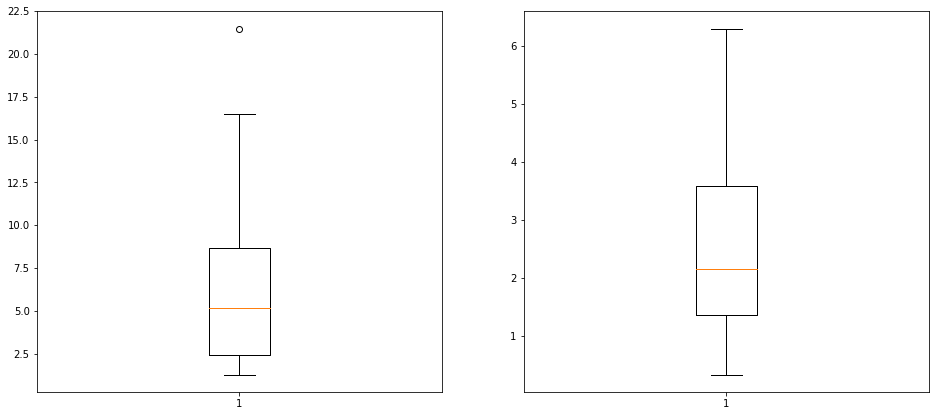

In [13]:
p_lt50p = list(species_level_performance_binary_df[species_level_performance_binary_df['Precision']<=0.5]['GT_TD_diff'])
p_lt50p = [val if ~np.isnan(val) else 0 for val in p_lt50p]
p_gt50p = list(species_level_performance_binary_df[species_level_performance_binary_df['Precision']>0.5]['GT_TD_diff'])

fig, (ax1, ax2) = plt.subplots(figsize=(16, 7), ncols=2)
ax1.boxplot(p_lt50p)
ax2.boxplot(p_gt50p)

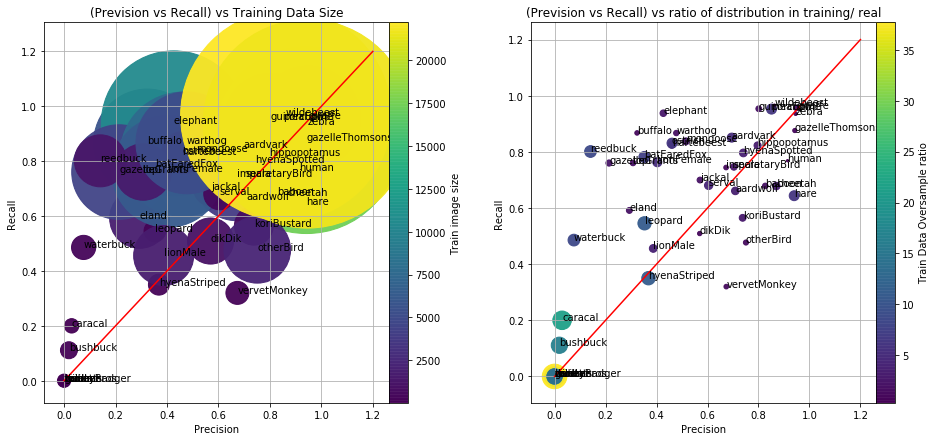

In [14]:
import matplotlib.pyplot as plt

# species_performance_metric = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/EDA_and_ModelEvaluation/metric_temp.csv'

# df_vis = pd.read_csv(species_performance_metric)
df_vis = species_level_performance_binary_df
df_vis = df_vis.fillna(0)
x = df_vis['Precision']
y = df_vis['Recall']

fig, (ax1, ax2) = plt.subplots(figsize=(16, 7), ncols=2)
#######################################
# Plot for precision vs recall for training data size
im1 = ax1.scatter(x, y, c=df_vis['Training_Data_Size'],\
            s=2*df_vis['Training_Data_Size'], alpha=0.95)

for i, txt in enumerate(df_vis['Species']):
    ax1.annotate(txt, (x[i], y[i]))
ax1.set_title('(Prevision vs Recall) vs Training Data Size')
ax1.set_xlabel('Precision')
ax1.set_ylabel('Recall')

cbar1 = fig.colorbar(im1, ax=ax1, pad=0)
cbar1.set_label('Train image size')

ax1.grid()
ax1.plot([0, 1.2], [0, 1.2], 'r-')


#######################################
# Plot of Precision vs recall for oversampling ratio
im2 = ax2.scatter(x, y, c=df_vis['GT_TD_diff'],\
            s=16*df_vis['GT_TD_diff'], alpha=0.95)

for i, txt in enumerate(df_vis['Species']):
    ax2.annotate(txt, (x[i], y[i]))
ax2.set_title('(Prevision vs Recall) vs ratio of distribution in training/ real')
ax2.set_xlabel('Precision')
ax2.set_ylabel('Recall')

# fig.colorbar(im2)
cbar2 = fig.colorbar(im2, ax=ax2, pad=0)
cbar2.set_label('Train Data Oversample ratio')


ax2.grid()
ax2.plot([0, 1.2], [0, 1.2], 'r-')

# Save the figure to the disk
fig.savefig('./Dashboard/Precision_Recall_{0}.jpg'.format(round_number))

In [15]:
species_level_performance_binary_df.to_csv('bootstrap_LowerBound50p/{0}_SS_s10_performance_level_1b.csv'.format(round_number), index=False)

# Level 2: Count
Given the model predicted the correct species, how good it is in the count.
1. **Absolute count per image** - # of animals in ground truth vs # of animals in predictions 
2. **Count per image-species** - # of animals in ground truth vs # of animals in predictions 
3. **Precision and Recall**

In [15]:
# Add parameters
k = 6
print(df_pred_gt_consolidated.shape)

(187686, 5)


In [16]:
# 1.
def get_count_level_performance(df_pred_gt_consolidated, level):
    """Level could be 'overall' or 'species'. The species is a particular species.
    """
    print(level)
    # Absolute Count per image
    df_pred_gt_consolidated_inter = df_pred_gt_consolidated.fillna(0)
    if level!="Overall":
        df_pred_gt_consolidated_inter = df_pred_gt_consolidated_inter[(df_pred_gt_consolidated_inter['species']==level) \
                                                                      & (df_pred_gt_consolidated_inter['groundtruth_counts']!=0)]
        
    df_pred_gt_consolidated_inter['groundtruth_counts'] = ['11' if val == '11-50' else val for val in df_pred_gt_consolidated_inter['groundtruth_counts']]
    df_pred_gt_consolidated_inter['groundtruth_counts'] = ['51' if val == '51+' else val for val in df_pred_gt_consolidated_inter['groundtruth_counts']]
    df_pred_gt_consolidated_inter['prediction_counts'] = ['11' if val == '11-50' else val for val in df_pred_gt_consolidated_inter['prediction_counts']]
    df_pred_gt_consolidated_inter['prediction_counts'] = ['51' if val == '51+' else val for val in df_pred_gt_consolidated_inter['prediction_counts']]
    # converting values to integer
    df_pred_gt_consolidated_inter['groundtruth_counts'] = [int(val) for val in df_pred_gt_consolidated_inter['groundtruth_counts']]
    df_pred_gt_consolidated_inter['prediction_counts'] = [int(val) for val in df_pred_gt_consolidated_inter['prediction_counts']]


    # Grouping by the animal counts by image
    df_pred_gt_consolidated_count = df_pred_gt_consolidated_inter.groupby(by='filename', as_index=False) \
                ['groundtruth_counts', 'prediction_counts'].sum()
    # ignore all cases with 0 groundtruth or prediction counts
    df_pred_gt_consolidated_count = df_pred_gt_consolidated_count[(df_pred_gt_consolidated_count['prediction_counts']!=0) \
                                                                      | (df_pred_gt_consolidated_count['groundtruth_counts']!=0)]

    df_pred_gt_consolidated_count['df_gt_pred'] = df_pred_gt_consolidated_count.groundtruth_counts - \
                                                        df_pred_gt_consolidated_count.prediction_counts
    df_pred_gt_consolidated_count['df_df_pred_abs'] = [abs(val) for val in df_pred_gt_consolidated_count['df_gt_pred']]

    # calculating correctness in +/- k variance of the groundtruth count
    total_image = len(set(df_pred_gt_consolidated_count.filename))
    
    if total_image == 0:
        return "Divide By Zero"
    accyracy_for_k_round = [round(df_pred_gt_consolidated_count[df_pred_gt_consolidated_count.df_df_pred_abs<=i].shape[0]/total_image, 5) \
                            for i in range(k)]

    for i in range(k):
        print("Accuray with {1} variance: {0}".format(accyracy_for_k_round[i], i))

    # plot bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(range(k), accyracy_for_k_round)
    ax.set_ylim([0, 1])
    ax.set_xlabel('Deviation')
    ax.set_ylabel('Accuracy')
    ax.set_title('Count Accuracy at different deviation on difference in gt vs prediction: {0}'.format(level))
    ax.grid()
    # Save the figure to the disk
    fig.savefig('./Dashboard/Accuracy_at_variance_bar_{1}_{0}.jpg'.format(round_number, level))
    
    return df_pred_gt_consolidated_count

Overall
Accuray with 0 variance: 0.45596
Accuray with 1 variance: 0.6691
Accuray with 2 variance: 0.75672
Accuray with 3 variance: 0.81076
Accuray with 4 variance: 0.85146
Accuray with 5 variance: 0.88386


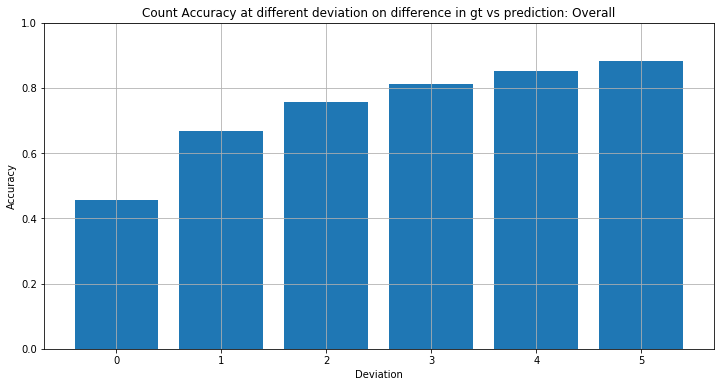

In [17]:
# Plot the overall level performance on count
df_pred_gt_consolidated_count = get_count_level_performance(df_pred_gt_consolidated, "Overall")

# Plot the species level performance on count
# for species in set(df_pred_gt_consolidated.species):
#     get_count_level_performance(df_pred_gt_consolidated, species)

<Figure size 432x288 with 0 Axes>

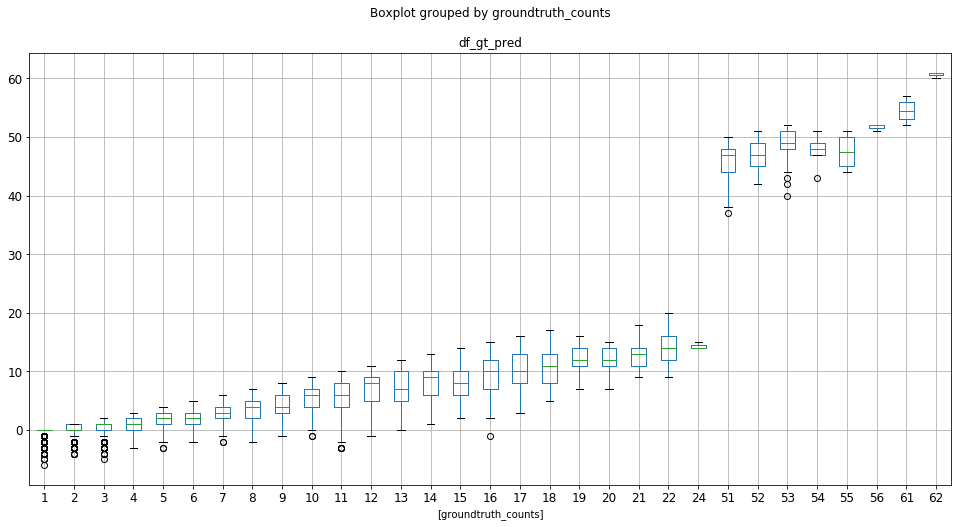

In [18]:
# Box Plot 
plt.figure()
boxplot = df_pred_gt_consolidated_count.boxplot(column=['df_gt_pred'], by=['groundtruth_counts'], fontsize='large', \
                                               figsize=(16, 8))
# Save the figure to the disk
plt.savefig('./Dashboard/Count_level_boxplot_{0}.jpg'.format(round_number))

/home/ubuntu/test_env/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


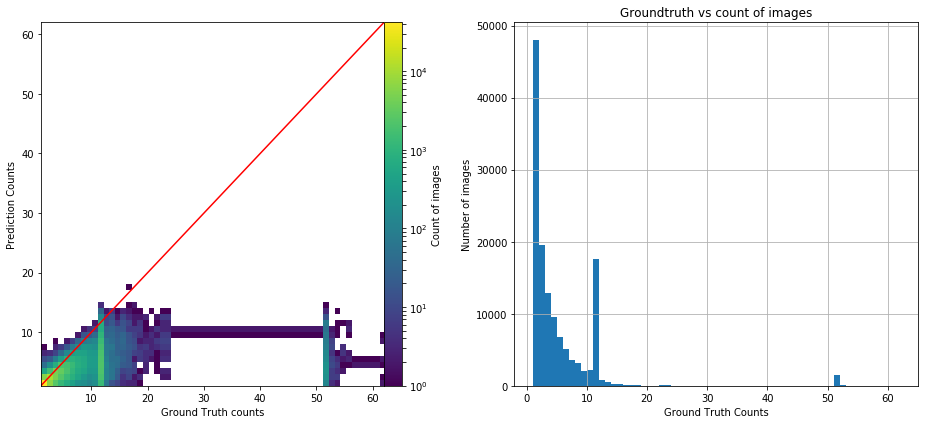

In [19]:
import matplotlib.pyplot as plt
import matplotlib.colors as mco
df_vis1 = df_pred_gt_consolidated_count
df_vis2 = df_pred_gt_consolidated_count
df_vis2.head()


fig, (ax1, ax2) = plt.subplots(figsize=(13, 6), ncols=2)

x = df_vis2.groundtruth_counts
y = df_vis2.prediction_counts

limit = 65
edges = np.unique(x)# np.arange(limit+1) + 0.5
bins = edges

out1 = ax1.hist2d(x, y, bins=bins, cmap=plt.viridis(), norm=mco.LogNorm())
img1 = out1[-1]

ax1.set_xlabel('Ground Truth counts')
ax1.set_ylabel('Prediction Counts')

cbar1 = fig.colorbar(img1, ax=ax1, pad=0)
cbar1.set_label('Count of images')

ax1.plot([0, limit+1], [0, limit+1], 'r-')

# ------------------------- #
x = df_vis2.groundtruth_counts
y = df_vis2.prediction_counts
edges = np.unique(x)
bins = edges

out2 = ax2.hist(x, bins=bins, normed=False)
img2 = out2[-1]
ax2.set_title('Groundtruth vs count of images')
ax2.set_xlabel('Ground Truth Counts')
ax2.set_ylabel('Number of images')
ax2.grid()

fig.tight_layout()
fig.savefig('./Dashboard/Histogram2d_for_groundtruth_prediction_{0}.jpg'.format(round_number))

## 48x48 confusion matrix for Classification

In [23]:
def get_multi_level_confusion_matrix(df_pred_gt_consolidated):
    """ 
    This is a function that works specifially of the prediction and groundtruth consolidated dataset.
    Look at the prediction_groundtruth_consolidation.py fuction for idea on the input data format.
    """
    # df_pred_gt_consolidated to dictionary with filenames as key.
    data_dict = {}
    for r, v in df_pred_gt_consolidated.to_dict('index').items():
        if v['filename'] not in data_dict.keys():
            data_dict[v['filename']]={}
            data_dict[v['filename']]['species']=[v['species']]
            data_dict[v['filename']]['groundtruth_counts']=[v['groundtruth_counts']]
            data_dict[v['filename']]['prediction_counts']=[v['prediction_counts']]
        else:
            data_dict[v['filename']]['species'].append(v['species'])
            data_dict[v['filename']]['groundtruth_counts'].append(v['groundtruth_counts'])
            data_dict[v['filename']]['prediction_counts'].append(v['prediction_counts'])

    # Creating the layout for the confusion matrix. Initializing with 0
    cm = {}
    for species_r in set(df_pred_gt_consolidated.species):
        cm[species_r] = {}
        for species_c in set(df_pred_gt_consolidated.species):
            cm[species_r][species_c] = 0

    # Filling up the confusion matrix
    for filename, val in data_dict.items():
        j = next(j for (j, x) in enumerate(val['groundtruth_counts']) if type(x)==type('String'))
        for i in range(len(val['species'])):
            if pd.isnull(val['groundtruth_counts'][i]) + pd.isnull(val['prediction_counts'][i]) == 0:
                cm[val['species'][i]][val['species'][i]] +=1
            elif pd.isnull(val['groundtruth_counts'][i]) and ~pd.isnull(val['prediction_counts'][i]):
                cm[val['species'][i]][val['species'][j]] +=1
                
    return pd.DataFrame(cm)

In [25]:
# print(data_dict)
confusion_matrix = get_multi_level_confusion_matrix(df_pred_gt_consolidated)
confusion_matrix.to_csv('bootstrap_LowerBound50p/{0}_species_classification_confusion_matrix.csv'.format(round_number), index=True)
confusion_matrix.head()

,aardvark,aardwolf,baboon,batEaredFox,buffalo,bushbuck,caracal,cheetah,civet,dikDik,eland,elephant,gazelleGrants,gazelleThomsons,genet,giraffe,guineaFowl,hare,hartebeest,hippopotamus,honeyBadger,human,hyenaSpotted,hyenaStriped,impala,jackal,koriBustard,leopard,lionFemale,lionMale,mongoose,ostrich,otherBird,porcupine,reedbuck,rhinoceros,rodents,secretaryBird,serval,topi,vervetMonkey,warthog,waterbuck,wildcat,wildebeest,zebra,zorilla
aardvark,57,0,0,2,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0
aardwolf,0,39,0,5,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,7,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
baboon,0,0,410,0,7,0,0,0,0,1,0,9,3,4,0,0,1,0,3,0,0,0,6,0,1,0,0,0,15,12,2,1,4,0,0,0,0,0,1,1,5,204,3,0,78,0,0
batEaredFox,6,2,0,43,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
buffalo,0,0,0,0,3986,0,0,1,0,1,14,479,15,8,0,6,9,0,9,28,0,1,4,0,2,0,0,0,9,7,2,6,8,0,0,0,0,0,0,17,3,285,9,0,2073,31,0


## Distribution of predicted box sizes

In [16]:
# Defining variabled
round_number = 'round1_ckpt69k'
filepath_list = glob.glob("/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/pred_snapshot_serengeti_s10_LB50p/{0}/Post_procession_of_infer_detection/msi_test_image_list_s10-*".format(round_number))
label_map_json = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/label_map.json'
label_map = dataprep_utils.get_label_map_from_json(label_map_json)
label_map_df = pd.DataFrame.from_dict(label_map, orient='index').reset_index()
label_map_df.columns = ['species', 'labels']
# Dimension of the raw image (overall)

In [12]:
df_pred_gt_consolidated = csc.combine_tfr_decoded_predictions(filepath_list)
df_pred_gt_consolidated = df_pred_gt_consolidated[df_pred_gt_consolidated['labels'].notnull()]
df_pred_gt_consolidated = pd.merge(left=df_pred_gt_consolidated,
                                   right=label_map_df,
                                   left_on=df_pred_gt_consolidated['labels'].astype(int),
                                   right_on=label_map_df['labels'].astype(int),
                                   how='left'
                                  )
df_pred_gt_consolidated = df_pred_gt_consolidated.drop(columns=['key_0', 'labels_y']).rename(columns={'labels_x':'labels'})
df_pred_gt_consolidated['xmax'] = df_pred_gt_consolidated['xmax']*1000
df_pred_gt_consolidated['xmin'] = df_pred_gt_consolidated['xmin']*1000
df_pred_gt_consolidated['ymax'] = df_pred_gt_consolidated['ymax']*750
df_pred_gt_consolidated['ymin'] = df_pred_gt_consolidated['ymin']*750
df_pred_gt_consolidated['width'] = df_pred_gt_consolidated['xmax'] - df_pred_gt_consolidated['xmin']
df_pred_gt_consolidated['height'] = df_pred_gt_consolidated['ymax'] - df_pred_gt_consolidated['ymin']
df_pred_gt_consolidated['area'] = round(df_pred_gt_consolidated['width']*df_pred_gt_consolidated['height'], 1)

In [13]:
label_map_df.head(2)

,species,labels
0,ostrich,19
1,lionMale,38


In [14]:
df_pred_gt_consolidated.head()

,filename,labels,score,xmax,xmin,ymax,ymin,species,width,height,area
0,S10/C04/C04_R1/S10_C04_R1_IMAG4723,17.0,1.0,999.206543,5.913353,739.328340,0.000000,wildebeest,993.293190,739.328340,734369.8
1,S10/I12/I12_R1/S10_I12_R1_IMAG0252,17.0,1.0,668.033004,321.667880,506.788194,320.625924,wildebeest,346.365124,186.162271,64480.1
2,S10/I12/I12_R1/S10_I12_R1_IMAG0252,17.0,1.0,386.531889,235.583797,484.476686,334.333465,wildebeest,150.948092,150.143221,22663.8
3,S10/I12/I12_R1/S10_I12_R1_IMAG0252,17.0,1.0,716.975927,680.020511,400.065288,356.263630,wildebeest,36.955416,43.801658,1618.7
4,S10/I12/I12_R1/S10_I12_R1_IMAG0252,17.0,1.0,214.387298,24.827728,500.106230,319.675304,wildebeest,189.559570,180.430926,34202.4


[238262.  32907.  18069.  12073.   9042.   7326.   5719.   4938.   4283.
   3825.   3415.   3096.   2791.   2779.   2453.   2289.   2038.   1946.
   1730.   1767.   1769.   1842.   2213.   4080.   5513.]


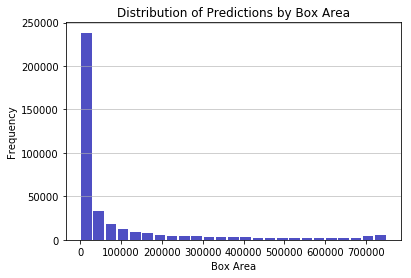

In [15]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=df_pred_gt_consolidated['area'], bins=25, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Box Area')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions by Box Area')
print(n)